In [1]:
using WaterLily
using LinearAlgebra
using Plots; gr()
include("examples/TwoD_plots.jl")
include("BiotSavart.jl")

∮ (generic function with 2 methods)

In [2]:

function BC_BiotSavart!(a,A,ω)
    N,n = WaterLily.size_u(a)
    @inside ω[I] = WaterLily.curl(3,I,a)
    area = ntuple(i->prod(N.-2)/(N[i]-2),n) # are of domain (without ghosts)
    for j ∈ 1:n, i ∈ 1:n
        k = i%2+1 # the only component not zero in the vorticity
        if i==j # Normal direction, Dirichlet
            for s ∈ (1,2,N[j])
                for I ∈ WaterLily.slice(N,s,j)
                    a[I,i] = A[i]
                    @WaterLily.loop a[I,i] += K(i,I,k,J)*ω[J] over J ∈ WaterLily.inside_u(N,i)
                end
            end
            # make global face flux zero
            # ∮u = (∮(a,N,N[j],j)-∮(a,N,2,j))/∮(ones((N...,j)),j)# mass flux imbalance in domain
            # @WaterLily.loop a[I,i] += ∮u/2 over I ∈ WaterLily.slice(N,2,j)
            # @WaterLily.loop a[I,i] -= ∮u/2 over I ∈ WaterLily.slice(N,N[j],j)
        else    # Tangential directions, Neumanns
            for s ∈ (1,N[j])
                for I ∈ WaterLily.slice(N,s,j)
                    a[I,i] = A[i]
                    @WaterLily.loop a[I,i] += K(i,I,k,J)*ω[J] over J ∈ WaterLily.inside_u(N,i)
                end
            end
        end
    end
end

BC_BiotSavart! (generic function with 1 method)

In [3]:

BC!(a,A,σ) = BC_BiotSavart!(a,A,σ)
# BC!(a,A,σ) = WaterLily.BC!(a,A)

BC! (generic function with 1 method)

In [4]:

# some definitons
U = 1
Re = 250
m, n = 2^6, 2^7
println("$m x $n: ", prod((m,n)))
radius = 16
center = m/2 + 1.5

# make a circle body
body = AutoBody((x,t)->√sum(abs2, x .- center) - radius)
z = [radius*exp(im*θ) for θ ∈ range(0,2π,length=33)]

# make a simulation
sim = Simulation((n,m), (U,0), radius; ν=U*radius/Re, body, T=Float64);


64 x 128: 8192


One step of projection method

1. Intermediate velocity from convection diffusion 
$$
\mathbf{u}^* = \mathbf{u}^n + Δt \left( \frac{1}{Re} ∇^2 \mathbf{u}^n - \mathbf{u}^n ⋅ ∇  \mathbf{u}^n \right)
$$
2. Apply Boundary condition on the domain edges
$$
\mathbf{u}^*(\mathbf{x}_b) = ∫_\mathcal{V} K(\mathbf{x}_b-\mathbf{y})×\mathbf{ω}(\mathbf{y}) \text{ d}\mathcal{V}(\mathbf{y}) \quad ∀ ∈ ∂Ω
$$
3. Compute the pressure field to satisfy divergence-free condition
$$
∇ ⋅ \left(\frac{Δt}{ρ}∇ p\right) = ∇ ⋅ \mathbf{u}^*
$$
4. Update the velocity field
$$
\mathbf{u}^{n+1} = \mathbf{u}^* - Δt ∇ p
$$
5. Update the boundary condition on the domain edges
$$
\mathbf{u}^*(\mathbf{x}_b) = ∫_\mathcal{V} K(\mathbf{x}_b-\mathbf{y})×\mathbf{ω}(\mathbf{y}) \text{ d}\mathcal{V}(\mathbf{y}) \quad ∀ ∈ ∂Ω
$$

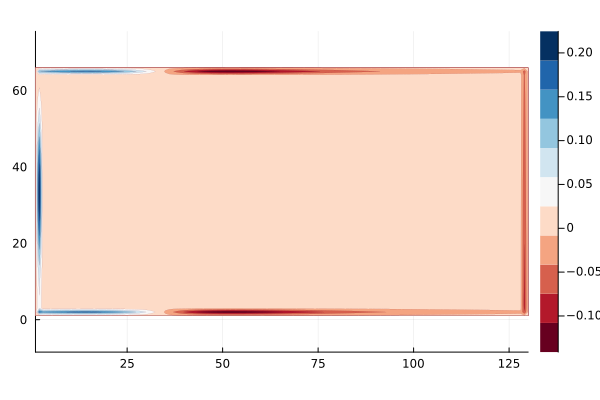

In [5]:

sim.flow.u⁰ .= sim.flow.u; sim.flow.u .= 0
# predictor u → u'
WaterLily.conv_diff!(sim.flow.f,sim.flow.u⁰,sim.flow.σ,ν=sim.flow.ν)
WaterLily.BDIM!(sim.flow); 
BC!(sim.flow.u,sim.flow.U,sim.flow.σ)
WaterLily.project!(sim.flow,sim.pois)
BC!(sim.flow.u,sim.flow.U,sim.flow.σ)
@inside sim.flow.σ[I] = WaterLily.div(I,sim.flow.u)
flood(sim.flow.σ)

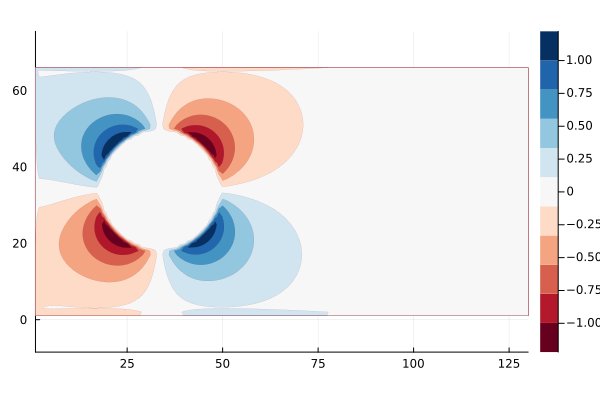

In [6]:
flood(sim.flow.u[:,:,2])

The issue is that $\mathcal{\omega}$ is linked to the velocity field by
$\mathbf{\omega} = \nabla\times\mathbf{u}$. The new velocity induced by the pressure changes $\mathbf{\omega}$, which changes the velocity on the boundary, which changes the divergence on the boundary, to which the pressure must adjust, changing the velocity field...

Coupled problem

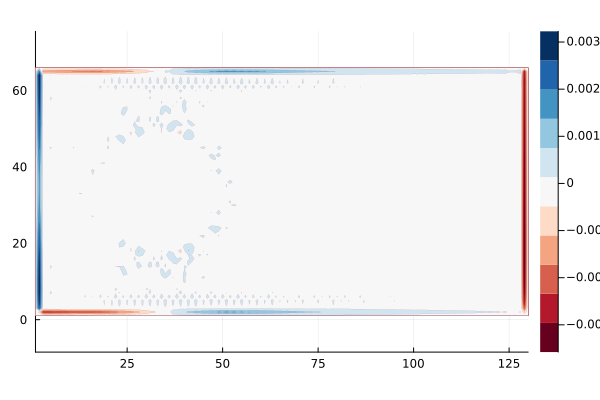

In [7]:

sim = Simulation((n,m), (U,0), radius; ν=U*radius/Re, body, T=Float64)
sim.flow.u⁰ .= sim.flow.u; sim.flow.u .= 0
# predictor u → u'
WaterLily.conv_diff!(sim.flow.f,sim.flow.u⁰,sim.flow.σ,ν=sim.flow.ν)
WaterLily.BDIM!(sim.flow); 
BC!(sim.flow.u,sim.flow.U,sim.flow.σ)
for i in 1:10
    WaterLily.project!(sim.flow,sim.pois)
    BC!(sim.flow.u,sim.flow.U,sim.flow.σ)
end
@inside sim.flow.σ[I] = WaterLily.div(I,sim.flow.u)
flood(sim.flow.σ)

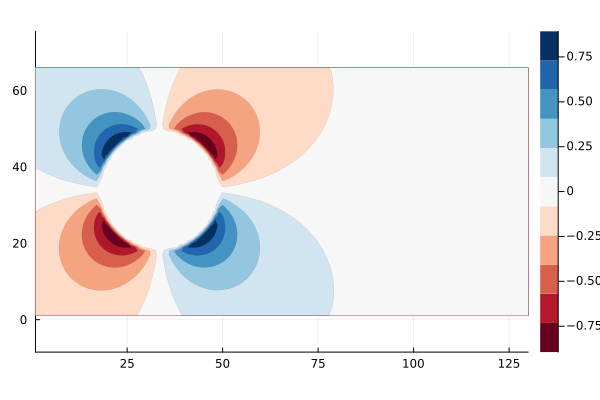

In [8]:
flood(sim.flow.u[:,:,2])

Standard BDIM does what?

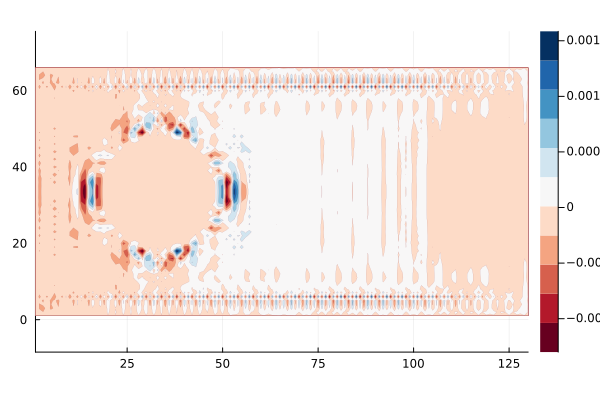

In [9]:
sim = Simulation((n,m), (U,0), radius; ν=U*radius/Re, body, T=Float64)
sim.flow.u⁰ .= sim.flow.u; sim.flow.u .= 0
# predictor u → u'
WaterLily.conv_diff!(sim.flow.f,sim.flow.u⁰,sim.flow.σ,ν=sim.flow.ν)
WaterLily.BDIM!(sim.flow); 
WaterLily.BC!(sim.flow.u,sim.flow.U)
WaterLily.project!(sim.flow,sim.pois)
WaterLily.BC!(sim.flow.u,sim.flow.U)
@inside sim.flow.σ[I] = WaterLily.div(I,sim.flow.u)
flood(sim.flow.σ)

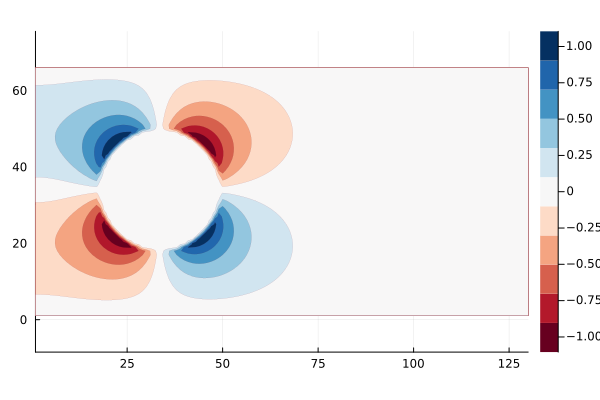

In [11]:
flood(sim.flow.u[:,:,2])